In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from scipy.fftpack import dct, idct
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import networkx as nx
import scipy.sparse as sp
import sys
from tqdm import tqdm
import pickle
import os

sns.set()

/opt/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow/python/framework/dty

We first convert the MNIST training digits into sparse vectors with int8 entries. I think this is a fair benchmark given that the digits are in 255 levels of gray scale. The next cell reports the total size of the training split.

In [2]:
# load the data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# ravel and normalize -- this may be useful later, but not used now
def ravelNorm(z):
    x = np.ravel(z)
    return x/np.linalg.norm(x,ord=1)

# We convert the matrix to sparse format. The numbers are in np.uint8.
Xs = [sp.coo_matrix(x,dtype=np.uint8) for x in x_train]
data = np.concatenate([x.data.astype(np.uint8) for x in Xs])
row = np.concatenate([x.row.astype(np.uint8) for x in Xs])
col = np.concatenate([x.col.astype(np.uint8) for x in Xs])
lengths = np.array([len(x.data) for x in Xs],dtype=np.uint16)
n_samples = np.array(len(Xs))

# compress file
file = './tmp/xtrain'
np.savez_compressed(file,vals=np.concatenate([data,row,col]),lengths=lengths)

# let's look at the size of the dataset
print('Size of training dataset in sparse uint8 and compressed format: ' + str(os.path.getsize(file+'.npz')/1e6) + 'MB')

# compare with compressed numpy
file = './tmp/xtrain_np'


Size of training dataset in sparse uint8 and compressed format: 9.808819MB


Let's check with just plain vanilla npz:

In [3]:
file = './tmp/xtrain_np'
np.savez_compressed(file,x_train=x_train)
print('Size of training dataset in uint8 and np compressed format: ' + str(os.path.getsize(file+'.npz')/1e6) + 'MB')

Size of training dataset in uint8 and np compressed format: 9.822208MB


This is impressive! Numpy already does an excellent job with 'np.savez_compressed. There probably is a lot of optimization that goes in it.

This is our benchmark: 60k digits at $\approx$9MB --- already pretty small! Can we reduce it further? 

We first convert everything to np.int16 so we can operate on these numbers without overflow.


In [4]:
X = np.array([np.ravel(x.astype(np.int16)) for x in x_train])

Our first step is to build a k nearest neighbor graph measuring distances using the **hamming distance**. We select l0 to keep everything integer. Beware: this takes a while to run.

In [5]:
# def l0(x,y):
#     return np.sum( (x-y) !=0)

nbrs = NearestNeighbors(n_neighbors=30, algorithm='ball_tree',n_jobs=-1,leaf_size=50,metric='hamming').fit(X)
distances, indices = nbrs.kneighbors(X)


In [6]:
# save
file = './tmp/knn'
np.savez_compressed(file,nbrs=nbrs,distances=distances,indices=indices)

Let's visualize some of the nearest neighbors.

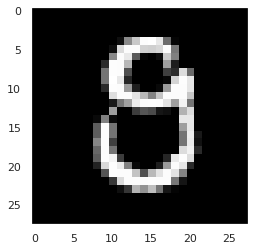

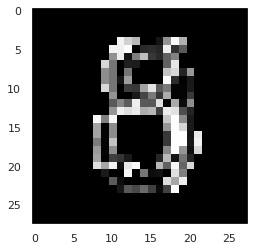

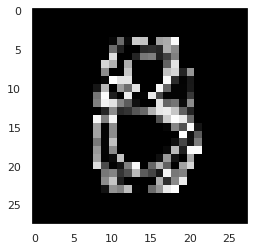

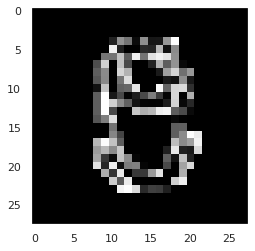

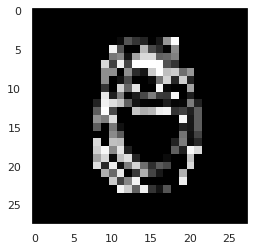

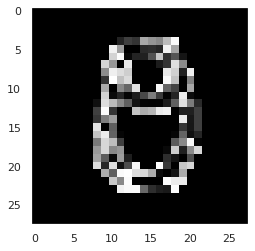

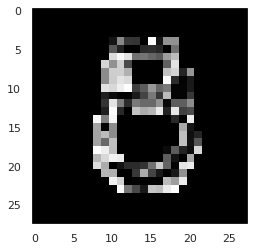

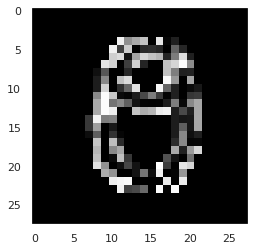

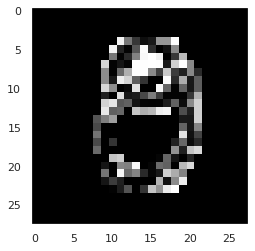

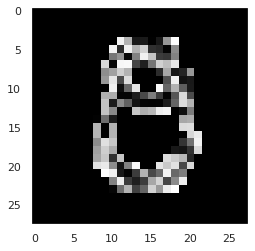

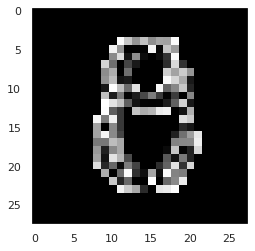

In [66]:
target_sample = 80
k = 0
max_plots = 10 # maximum number of plots
for C in x_train[indices[target_sample]]:
    Cr = C.reshape(x_train[target_sample].shape)
    if k==0:
        Cref = Cr
        plt.imshow(np.abs(Cr),cmap='gray')
    else:
        plt.figure()
        plt.imshow(np.abs(Cr-Cref),cmap='gray')
    plt.grid(None)
    k+=1
    if k>max_plots:
        break

Now we do a simple test. Each digit has 30 nearest neighbors in the above graph. We check the average reduction in size if for each neighborhood we keep the differences a opposed to the full digit. This should provide some evidence if compression is actually feasible or not. We will then try to use fancy techniques.

We measure "compression" in terms of non-zero entries of the dataset for now.

In [21]:
# create dataframe for storing results
df = pd.DataFrame(np.zeros(len(x_train)),columns=['Uncompressed'])
df['diff'] = 0
df['quant'] = 0

thresh = 5
# measure number of non-zero entries
for i in range(len(indices)):
    ix = indices[i]
    df.loc[i,'Uncompressed'] = (np.sum([np.count_nonzero(X[i])  for i in ix[1:]])+np.count_nonzero(X[ix[0]]))/len(ix)
    df.loc[i,'diff'] = (np.sum([np.count_nonzero(X[i]-X[ix[0]])  for i in ix[1:]])+np.count_nonzero(X[ix[0]]))/len(ix)
    df.loc[i,'quant'] = (np.sum([np.sum(np.abs(X[i]-X[ix[0]])>=2)  for i in ix[1:]])+np.count_nonzero(X[ix[0]]))/len(ix)

Mean Uncompressed: 122.15541166666726
Mean Diff: 144.20812388888814
Quantized Diff: 140.41405166666814


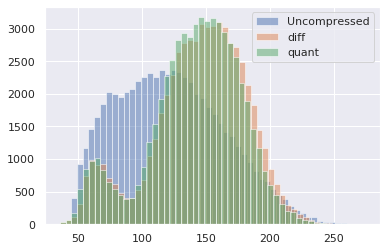

In [22]:
# Let's compute summary statistics!
print('Mean Uncompressed: '+str(df['Uncompressed'].mean()))
print('Mean Diff: '+str(df['diff'].mean()))
print('Quantized Diff: '+str(df['quant'].mean()))

df['Uncompressed'].hist(bins=50,alpha=.5,label='Uncompressed')
df['diff'].hist(bins=50,alpha=.5,label='diff')
df['quant'].hist(bins=50,alpha=.5,label='quant')
plt.legend()

Now let's build the similarity graph using networkX.

In [42]:
# Build graph with nodes ordered from 0 to size of dataset
n_nodes = len(x_train)
G = nx.Graph()
G.add_nodes_from(range(n_nodes))

# Create dictionary of edge connections
# d will be the distance between nodex
edge_list = [(i,j,{'d':d}) for i in range(n_nodes)  for (j,d) in zip(indices[i,1:],distances[i,1:]) ] 

# add edges
G.add_edges_from(edge_list)

# check if graph is connected
n_components = len(list(nx.connected_components(G)))
if n_components == 1:
    print('Connected!')
else:
    print('Not connected...')

Connected!


In [43]:
# compute mst
T = nx.minimum_spanning_tree(G,weight='d')

# compute most connected nodes


In [61]:
# weights
w = [e[2]['d']*28*28 for e in  T.edges(data=True)]

# original size
original = [np.count_nonzero(x)  for x in X ]

(array([7.000e+00, 3.000e+01, 1.070e+02, 2.600e+02, 5.670e+02, 9.080e+02,
        9.240e+02, 1.067e+03, 1.372e+03, 1.354e+03, 1.588e+03, 2.313e+03,
        2.251e+03, 2.518e+03, 3.448e+03, 3.192e+03, 3.405e+03, 4.014e+03,
        3.568e+03, 3.399e+03, 3.849e+03, 2.945e+03, 2.723e+03, 2.883e+03,
        2.115e+03, 1.831e+03, 1.886e+03, 1.249e+03, 1.031e+03, 9.180e+02,
        6.060e+02, 4.660e+02, 3.740e+02, 2.380e+02, 2.000e+02, 1.520e+02,
        7.000e+01, 6.200e+01, 3.700e+01, 2.400e+01, 2.200e+01, 1.300e+01,
        4.000e+00, 4.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00]),
 array([ 34.  ,  40.34,  46.68,  53.02,  59.36,  65.7 ,  72.04,  78.38,
         84.72,  91.06,  97.4 , 103.74, 110.08, 116.42, 122.76, 129.1 ,
        135.44, 141.78, 148.12, 154.46, 160.8 , 167.14, 173.48, 179.82,
        186.16, 192.5 , 198.84, 205.18, 211.52, 217.86, 224.2 , 230.54,
        236.88, 243.22, 249.56, 255.9 , 262.24, 268.58, 274.92, 281.26,
        287.6 , 

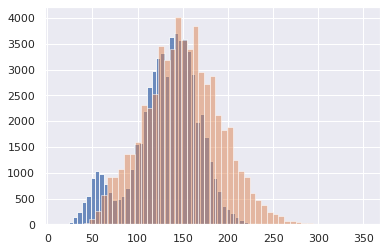

In [63]:
plt.hist(w,bins=50,alpha=.8)
plt.hist(original,bins=50,alpha=.5)

In [64]:
np.mean(w)

130.89936498941648

In [65]:
np.mean(original)

149.9026

In [ ]:
# measure betweeness
cent = nx.closeness_centrality(T)

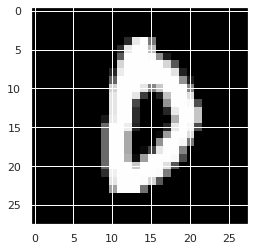

In [86]:
plt.imshow(x_train[pd.Series(cent).sort_values().index[-204]],cmap='gray')

In [91]:

# compress file
file = './tmp/xtrain_vals'
np.savez_compressed(file,vals=np.concatenate([x[x!=0] for x in x_train]).sort())

# let's look at the size of the dataset
print('Size of training dataset in sparse uint8 and compressed format: ' + str(os.path.getsize(file+'.npz')/1e6) + 'MB')

Size of training dataset in sparse uint8 and compressed format: 0.000332MB
